In [14]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import dedalus.public as d3
import h5py

from src.global_constants import *

save = False
def save_figure(path, dpi=None):
    if not path.parents[0].is_dir():
        path.parents[0].mkdir(parents=True)
    if save:
        plt.savefig(path, dpi=300 if dpi is None else dpi, bbox_inches='tight')

# Initial conditions tests

In [2]:
Lx, Lz = 1, 2
Nx, Nz = 64, 128
dealias = 3/2

coords = d3.CartesianCoordinates('x', 'z')
dist = d3.Distributor(coords, dtype=np.float32)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.RealFourier(coords['z'], size=Nz, bounds=(-Lz/2, Lz/2), dealias=dealias)
x, z = dist.local_grids(xbasis, zbasis)

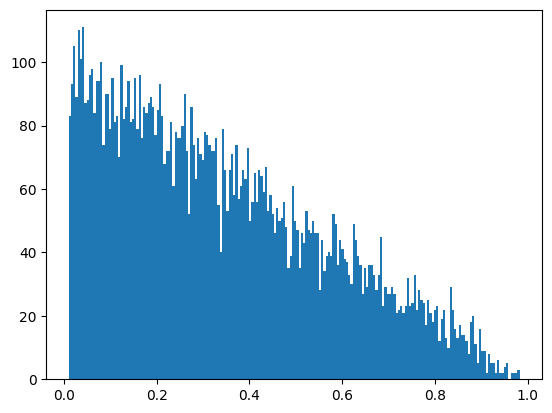

In [3]:
def rand_min_spaced(T, n, min_space):
    assert 0 < T and min_space * n < T
    x = (T - min_space * n) * np.random.rand(n)
    x = np.sort(x)
    dx = np.diff(x)
    dx += min_space
    x = np.cumsum(np.insert(dx, 0, 0)) + x[0]
    return x

al, bl = [], []
for i in range(10000):
    a, b = rand_min_spaced(1.0, 2, 0.01)
    al.append(a)
    bl.append(b)
al = np.array(al)
bl = np.array(bl)
delta = bl - al

plt.hist(delta, bins=200);

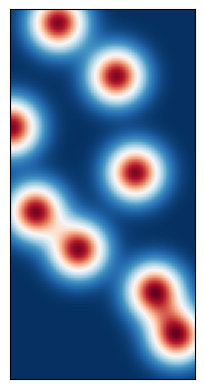

In [4]:
width = 1.0
n_shear = 2

velocity = np.zeros((Nx, Nz), dtype=np.float32)

x_pos = rand_min_spaced(1, n_shear*4, min_space=0.1)
z_pos = rand_min_spaced(2, n_shear*4, min_space=0.2) - 1
np.random.shuffle(x_pos)
np.random.shuffle(z_pos)
for (x1, z1) in zip(x_pos, z_pos):
    xs = (x-x1) / width
    zs = (z-z1) / width
    velocity += np.exp(-xs**2/0.02 - zs**2/0.02)
plt.imshow(velocity.T, cmap='RdBu_r')
plt.xticks([])
plt.yticks([]);

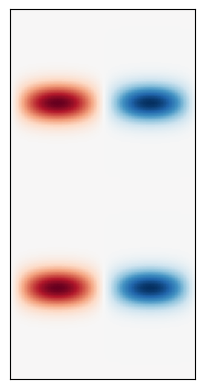

In [5]:
# velocity 
n_sinusoids = 2
velocity = np.zeros((Nx, Nz), dtype=np.float32)
velocity += 0.1 * np.sin(n_sinusoids*np.pi*x/Lx) * np.exp(-(z-0.5)**2/0.01)
velocity += 0.1 * np.sin(n_sinusoids*np.pi*x/Lx) * np.exp(-(z+0.5)**2/0.01)

plt.imshow(velocity.T, cmap='RdBu_r')
plt.xticks([])
plt.yticks([]);
# plt.colorbar();

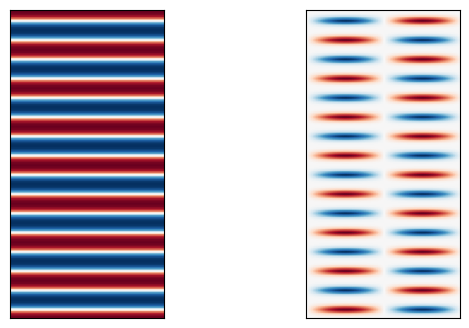

In [7]:
from src.generate_sf import init_standard_shear

# shear width
tracer_init = np.zeros((Nx, Nz), dtype=np.float32)
velocity = np.zeros((Nx, Nz), dtype=np.float32)

tracer_init, velocity = init_standard_shear(x, z, Lx, Nx, Nz, n_shear=16, width=2.0)
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
axes[0].imshow(tracer_init.T, cmap='RdBu_r')
axes[1].imshow(velocity.T, cmap='RdBu_r')
# plt.colorbar()
for ax in axes:
    plt.sca(ax)
    plt.xticks([])
    plt.yticks([])

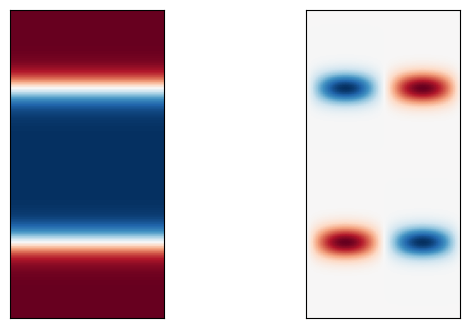

In [8]:
# multiple shear
tracer_init = np.zeros((Nx, Nz), dtype=np.float32)
velocity = np.zeros((Nx, Nz), dtype=np.float32)

n_shear = 2
z_shear = np.array([1/n_shear + 2 * n/n_shear for n in range(n_shear)]) - 1
for i, z1 in enumerate(z_shear):
    sign = 2 * (i%2) - 1
    zs = n_shear * (z-z1) / 2
    tracer_init[:,:] += sign * 1/2 * np.tanh(zs/0.1)
    velocity += 0.1 * np.sin(sign*2*np.pi*x/Lx) * np.exp(-zs**2/0.01)
tracer_init[:,:] += 1/2

fig, axes = plt.subplots(1, 2, figsize=(7, 4))
vmax = 1.0 / 2
norm = mcolors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
axes[0].imshow(tracer_init.T, cmap='RdBu_r', norm=norm)
axes[1].imshow(velocity.T, cmap='RdBu_r')
# plt.colorbar()
for ax in axes:
    plt.sca(ax)
    plt.xticks([])
    plt.yticks([])

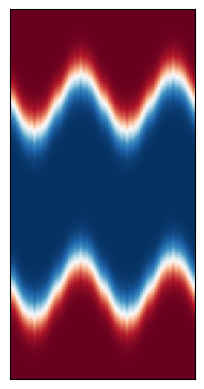

In [13]:
# sinusoïdal shear
tracer_init = np.zeros((Nx, Nz), dtype=np.float32)

tracer_init[:,:] = 1/2 + 1/2 * (np.tanh((z-0.5)/0.1) - np.tanh((z+0.5)/0.1))
for i in range(Nx):
    # roll by a sinusoidal shift
    tracer_init[i,:] = np.roll(tracer_init[i,:], int(10*np.sin(4*np.pi*i/Nx)))
plt.imshow(tracer_init.T, cmap='RdBu_r')
plt.xticks([])
plt.yticks([]);

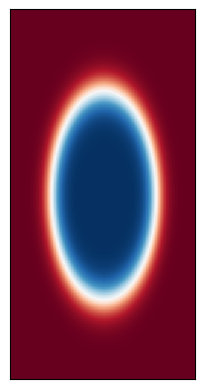

In [11]:
# circular shear
tracer_init = np.zeros((Nx, Nz), dtype=np.float32)

distances = np.sqrt(4.0*(x - 1/2)**2 + (z - 0.0)**2)
distances -= distances.mean()

tracer_init = np.tanh(10*distances + 2)

vmax = 1.0
norm = mcolors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
plt.imshow(tracer_init.T, cmap='RdBu_r', norm=norm)
plt.xticks([])
plt.yticks([]);

# Visualization

## Shear flow

In [38]:
# shear flow
################################################
exp_name = 'shearflow2d_final'
finished_generating = True
reynolds = 5e4
schmidt = 10.0
Nx, Ny = 128, 256
init = 'default'
n_shear = 2
n_blobs = 2
width = 1.0
################################################

# load data
save_name = filename_sf.format(Nx, Ny, reynolds, schmidt,width, n_shear, n_blobs)
dname = OUTPUT_PATH / exp_name / save_name
nfiles = len(list(dname.glob('*'))) - 1 + int(finished_generating)
print(save_name)
if nfiles == -1: 
    print("NO FILE")
x = []
for i in tqdm(range(1,nfiles+1)):
    fpath = dname / f"{save_name}_s{i}.h5"
    if not fpath.exists():
        print(f"{fpath} does not exist")
        break
    hf = h5py.File(fpath, 'r')
    xt = np.stack([
        np.array(hf['tasks']['tracer']),
        np.array(hf['tasks']['shear_velocity'])[:,0,...],  # shear
        np.array(hf['tasks']['vorticity']),
        np.array(hf['tasks']['shear_velocity'])[:,1,...],  # velocity
        np.array(hf['tasks']['pressure']),
    ], axis=1)
    x.append(xt)
x = np.concatenate(x)
if finished_generating:
    x = x[:200]
x.shape

__shearflow2d_reyn5_0ep04_schm1_0ep01_Nx128_Ny256_init_default_n_sh2_n_si2_widt1_0ep00_suff_


  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_3368609/3078507086.py:37: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  np.array(hf['tasks']['tracer']),
/tmp/ipykernel_3368609/3078507086.py:38: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  np.array(hf['tasks']['shear_velocity'])[:,0,...],  # shear
/tmp/ipykernel_3368609/3078507086.py:39: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  np.array(hf['tasks']['vorticity']),
/tmp/ipykernel_3368609/3078507086.py:40: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  np.array(hf['tasks']['shear_velocity'])[:,1,...],  # velocity
/tmp/ipykernel_3368609/3078507086.py:41: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0.

(200, 5, 128, 256)

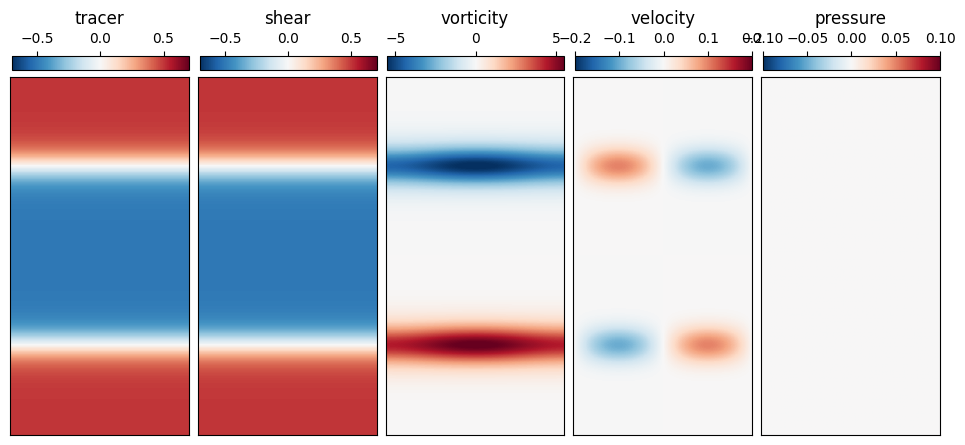

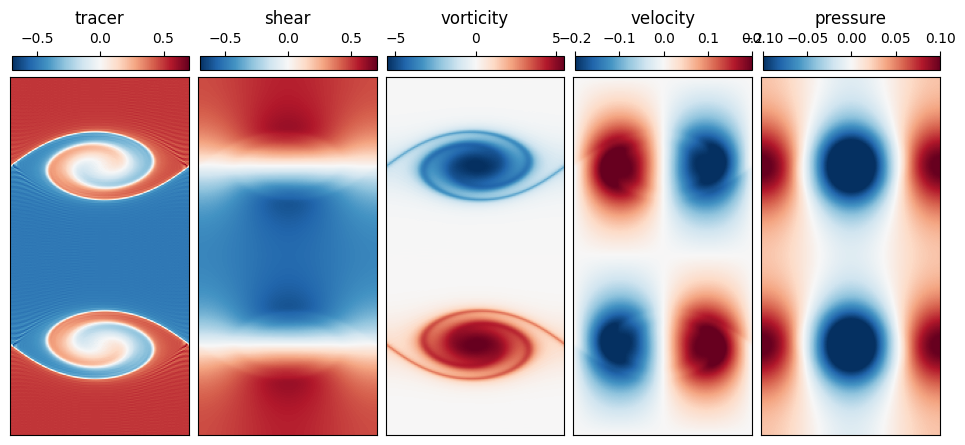

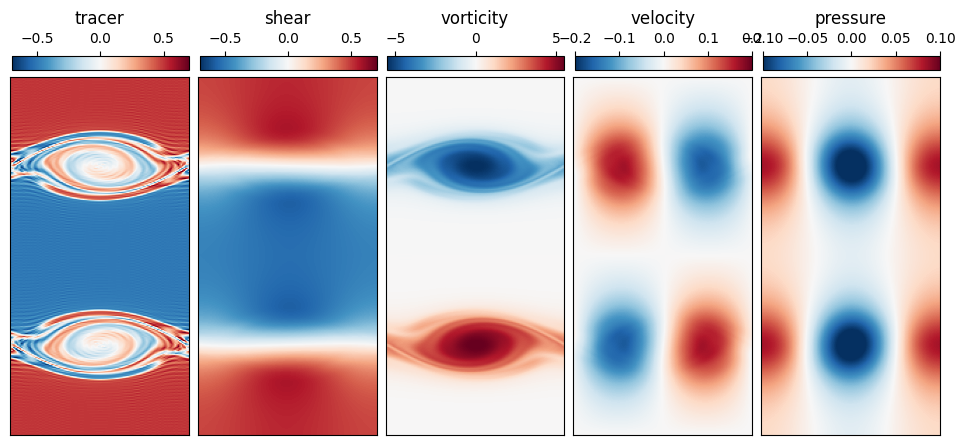

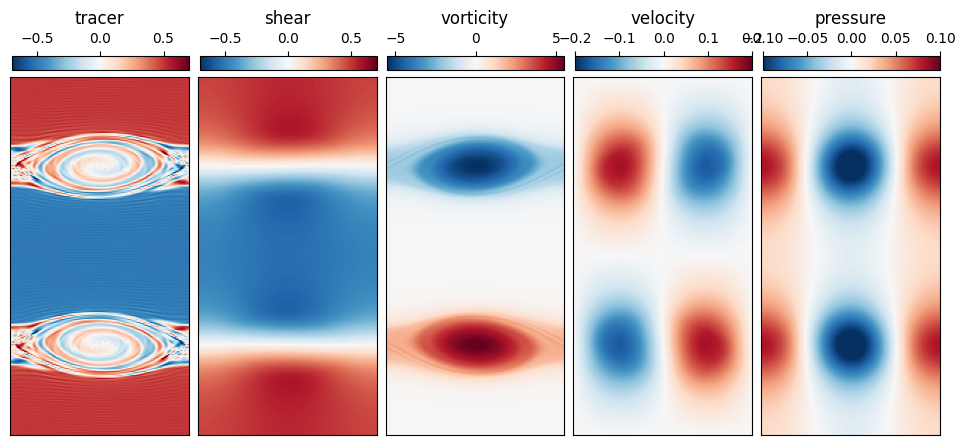

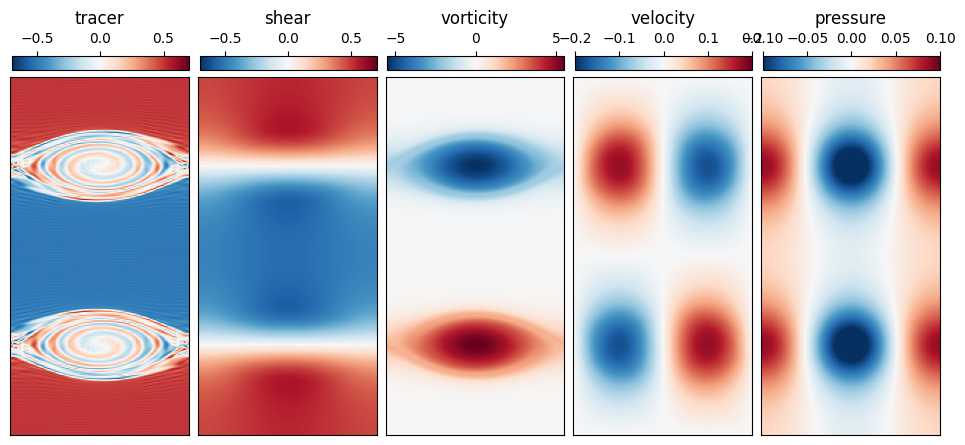

In [39]:
# define plotting function

def ploter_im(x):
    fig, axes = plt.subplots(1, 5, figsize=(12,14))
    def plot_one_axis(ax, y, vmax=None):
        if vmax is None:
            vmax = np.max(np.abs(y)) + 1e-6
        norm = mcolors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
        im = ax.imshow(y.T[::-1,:], cmap='RdBu_r', norm=norm)
        cbaxes = ax.inset_axes([0.01, 1.02, 0.99, 0.04])
        cbar = fig.colorbar(im, cax=cbaxes, orientation='horizontal')
        cbar.ax.tick_params(axis='x', direction='out', labeltop=True, labelbottom=False, bottom=False, top=True)
    # fig.suptitle(f"Time {i/10:.2f}", fontsize=16, y=0.7)
    axes[0].set_title('tracer')
    axes[1].set_title('shear')
    axes[2].set_title('vorticity')
    axes[3].set_title('velocity')
    axes[4].set_title('pressure')
    plot_one_axis(axes[0], x[0,:,:], vmax=0.7)
    plot_one_axis(axes[1], x[1,:,:], vmax=0.7)
    plot_one_axis(axes[2], x[2,:,:], vmax=5.5)
    plot_one_axis(axes[3], x[3,:,:], vmax=0.2)
    plot_one_axis(axes[4], x[4,:,:], vmax=0.1)
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    fig.subplots_adjust(wspace=0.05)

for i in range(0, x.shape[0], x.shape[0]//5):
# for i in range(5):
    ploter_im(x[i])

## Rayleigh Benard

In [58]:
# rayleigh benard
################################################
exp_name = "rbc2d_final"
finished_generating = True
rayleigh = 1e8
prandlt = 1.0
Nx, Ny = 512, 128
init = 'default'
seed = 40
dT = 1.0
################################################

# load data
save_name = filename_rbc.format(Nx, Ny, rayleigh, prandlt, dT, seed)
dname = OUTPUT_PATH / exp_name / save_name
nfiles = len(list(dname.glob('*'))) - 1 + int(finished_generating)
print(save_name)
if nfiles == -1: 
    print("NO FILE")
x = []
for i in tqdm(range(1,nfiles+1)):
    fpath = dname / f"{save_name}_s{i}.h5"
    if not fpath.exists():
        print(f"{fpath} does not exist")
        break
    hf = h5py.File(fpath, 'r')
    xt = np.stack([
        np.array(hf['tasks']['buoyancy']),
        np.array(hf['tasks']['pressure']),
        np.array(hf['tasks']['vorticity']),
        np.array(hf['tasks']['unknown'][:,0,...]), # unknown 1
        np.array(hf['tasks']['unknown'][:,1,...]), # unknown 2
    ], axis=1)
    x.append(xt)
x = np.concatenate(x)
if finished_generating:
    x = x[:200]
x.shape

__rbc2d_ray1_0ep08_pra1_0ep00_Nx512_Ny128_ini_default_see40_dT1_0ep00_suf_


  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_2072766/241182239.py:32: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  np.array(hf['tasks']['buoyancy']),
/tmp/ipykernel_2072766/241182239.py:33: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  np.array(hf['tasks']['pressure']),
/tmp/ipykernel_2072766/241182239.py:34: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  np.array(hf['tasks']['vorticity']),
100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


(200, 5, 512, 128)

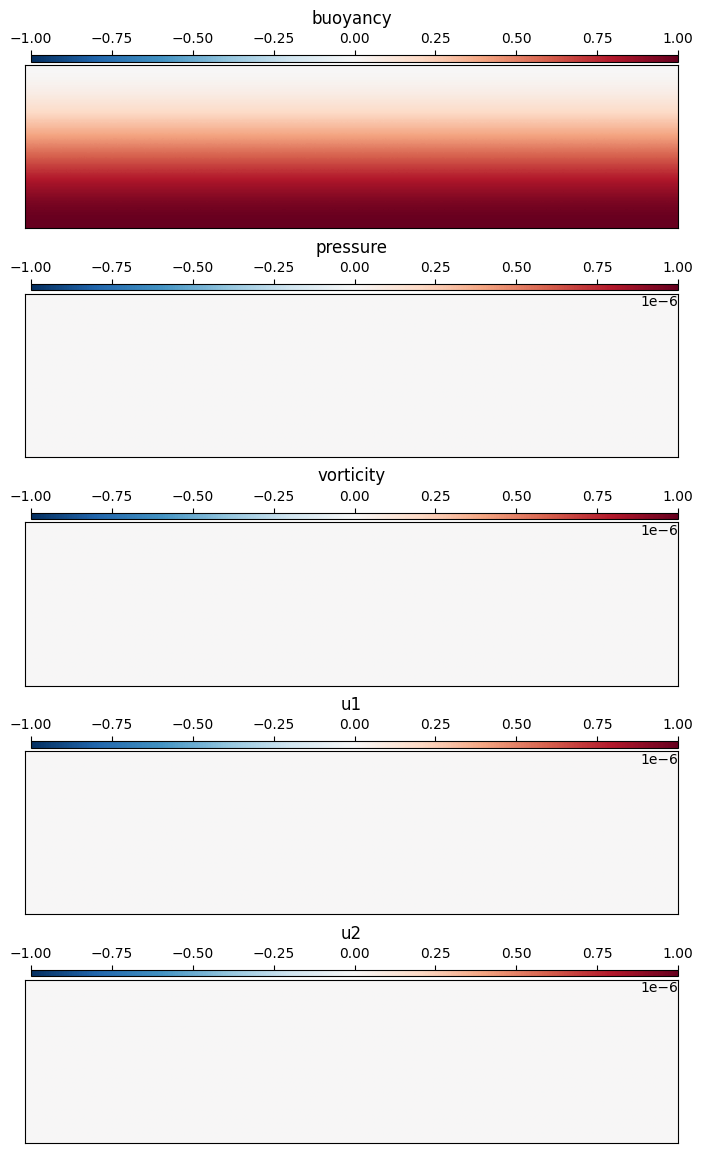

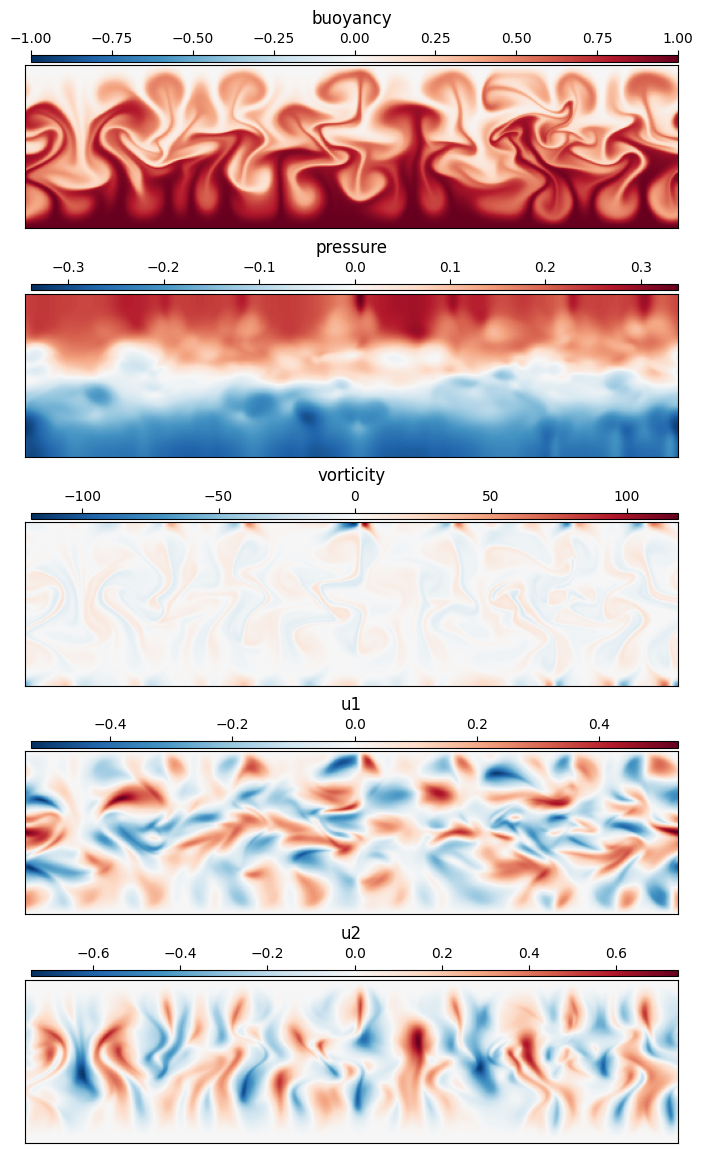

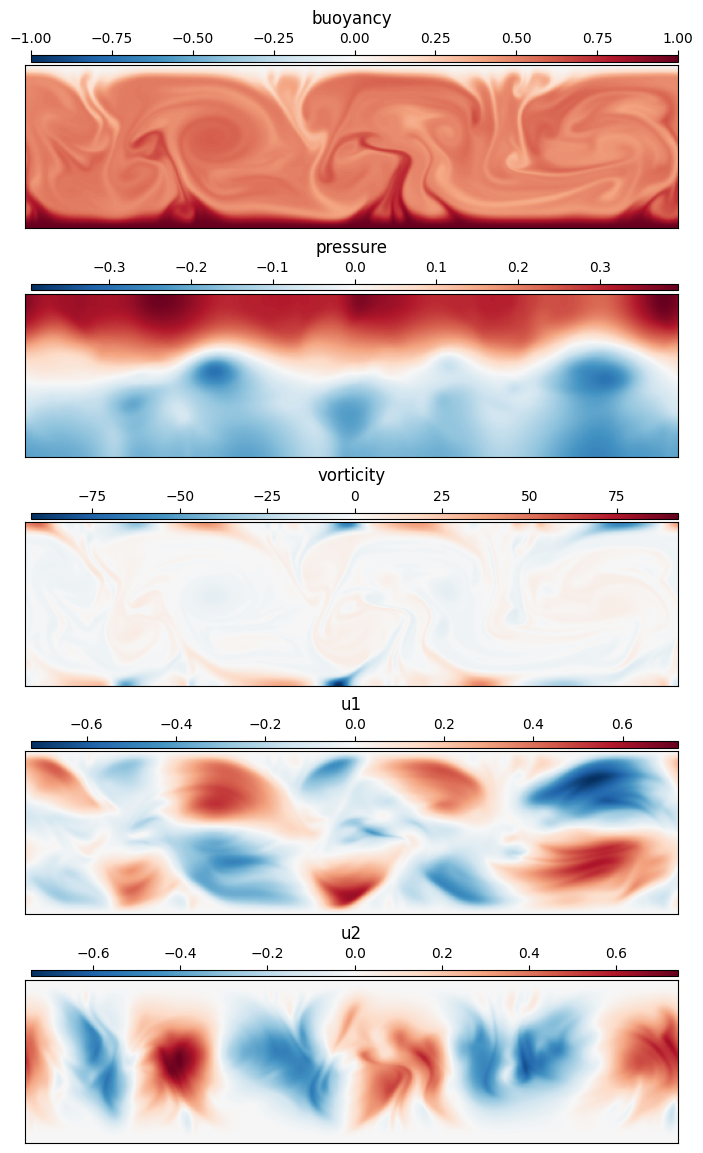

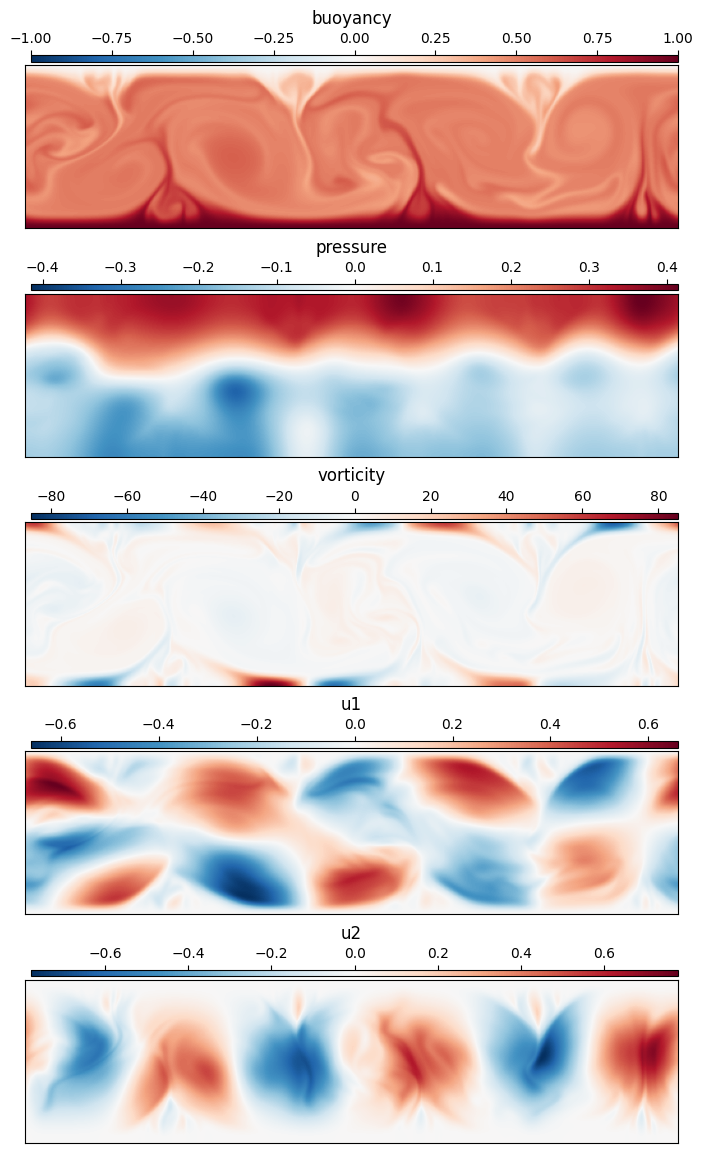

In [52]:
# define plotting function

def ploter_im(x):
    fig, axes = plt.subplots(5, 1, figsize=(12,14))
    def plot_one_axis(ax, y, vmax=None):
        if vmax is None:
            vmax = np.max(np.abs(y)) + 1e-6
        norm = mcolors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
        im = ax.imshow(y.T[::-1,:], cmap='RdBu_r', norm=norm)
        cbaxes = ax.inset_axes([0.01, 1.02, 0.99, 0.04])
        cbar = fig.colorbar(im, cax=cbaxes, orientation='horizontal')
        cbar.ax.tick_params(axis='x', direction='out', labeltop=True, labelbottom=False, bottom=False, top=True)
    # fig.suptitle(f"Time {i/4:.2f}", fontsize=16, y=0.95)
    axes[0].set_title('buoyancy')
    axes[1].set_title('pressure')
    axes[2].set_title('vorticity')
    axes[3].set_title('u1')
    axes[4].set_title('u2')
    plot_one_axis(axes[0], x[0,:,:], vmax=1.0)
    plot_one_axis(axes[1], x[1,:,:])
    plot_one_axis(axes[2], x[2,:,:])
    plot_one_axis(axes[3], x[3,:,:])
    plot_one_axis(axes[4], x[4,:,:])
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    fig.subplots_adjust(hspace=0.4)

for i in range(0, x.shape[0], x.shape[0]//4):
    ploter_im(x[i])